In [38]:
#default_exp models

In [1]:
#export

from tensorflow.keras.layers import Activation, \
Conv2D, Dense, Input, Conv2DTranspose, Dense, Flatten, \
Dropout, Concatenate, BatchNormalization, Reshape, \
UpSampling2D

from tensorflow_addons.layers import InstanceNormalization

from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LeakyReLU

import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
from datetime import datetime
from .dataloader import Data, TestData



ModuleNotFoundError: No module named 'dataloader'

In [3]:
os.chdir('../')
from outpainting.dataloader import Data, TestData

In [4]:
#export

data = Data()
test_data = Data()

TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 256, 3)
EPOCHS = 500
BATCH_SIZE = 1

MASK_PERCENTAGE = .25

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "checkpoint/"
SAVED_IMAGES = 'saved_images/'




In [9]:
#export

def discriminator_loss(y_true, y_pred):
    
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, EPSILON)) + tf.math.log(tf.maximum(1. - y_pred, EPSILON)))

In [26]:
#export

class ConvolutionBlock(tf.keras.Model):
    def __init__(self, filter_size, kernel_size, 
               strides=2, activation=LeakyReLU, 
               dropout_rate=0.2, norm=True):
        
        super(ConvolutionBlock, self).__init__(name='')
        
        self.conv = Conv2D(filter_size, kernel_size=kernel_size, 
                  strides=strides, padding='same', activation=activation())
    
        if dropout_rate is not None:
            self.drop = Dropout(dropout_rate)
        if norm:
            self.ins_norm = InstanceNormalization()
    
    def call(self, input_tensor, training=False):
        
        x = self.conv(input_tensor)
        
        if 'drop' in self.__dict__:
            x = self.drop(x, training=training)
        if 'norm' in self.__dict__:
            x = self.ins_norm(x, training=training)
        
        return x
    
def discriminator(d_input_shape):
    inp = Input(shape=d_input_shape)
    conv_block1 = ConvolutionBlock(32, 5, strides=2, 
                                   norm=False)(inp)
    conv_block2 = ConvolutionBlock(64, 5, strides=2)(conv_block1)
    conv_block3 = ConvolutionBlock(64, 5, strides=2)(conv_block2)
    conv_block4 = ConvolutionBlock(128, 5, strides=2)(conv_block3)
    conv_block5 = ConvolutionBlock(128, 5, strides=2)(conv_block4)
    
    
    flat = Flatten()(conv_block5)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)
    
    
    return Model(inp, d_output)
    

In [11]:
#export

def generator_loss(y_true, y_pred):
    G_MSE_loss = K.mean(K.square(y_pred - y_true))
    
    return G_MSE_loss - ALPHA * tf.reduce_mean(tf.math.log(tf.maximum(y_pred, EPSILON)))



In [13]:
#export

class GeneratorConvolutionBlock(tf.keras.Model):
    
    def __init__(self, filter_size, kernel_size=4, strides=2, 
                 activation=LeakyReLU, dropout_rate=0.2,
                 norm=True, dilation=1):
        
        super(GeneratorConvolutionBlock, self).__init__(name='')
        
        self.conv = Conv2D(filter_size, kernel_size=kernel_size, 
                             strides=strides, padding='same', activation=activation())
        
        if dropout_rate is not None:
            self.drop = Dropout(dropout_rate)
        
        if norm:
            self.ins_norm = InstanceNormalization()
    
    def call(self, input_tensor, training=False):
        
        x = self.conv(input_tensor)
        
        if 'drop' in self.__dict__:
            x = self.drop(x)
        
        if 'ins_norm' in self.__dict__:
            x = self.ins_norm(x)
            
        return x
            
        

In [27]:
#export

def generator(g_input_shape):
    
    g_input = Input(shape=g_input_shape)
    
    g1 = GeneratorConvolutionBlock(64, 4, strides=1)(g_input)
    g2 = GeneratorConvolutionBlock(128, 4, strides=2)(g1)
    g3 = GeneratorConvolutionBlock(256, 4, strides=2)(g2)
    
    g4 = GeneratorConvolutionBlock(512, 4, strides=1)(g3)
    g5 = GeneratorConvolutionBlock(512, 4, strides=1)(g4)
    
    t1 = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(g5)
    t2 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(t1)
    
    g6 = GeneratorConvolutionBlock(64, 4, strides=1)(t2)
    
    out = Conv2D(3, kernel_size=4, strides=(1, 1), 
                 activation='tanh', padding='same')(g6)
    
    return Model(g_input, out)
    

In [15]:
# export

def mask_width(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:, new_width:]
    return image, missing_part


def get_masked_images(images):
    mask_images = []
    missing_images = []
    images = images
    for image in images:
        mask_image, missing_image = mask_width(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images), np.array(missing_images)


def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

In [16]:
# Masking, Demasking example
# Note: IPython display gives false colors.
x = data.get_data(1)

# a will be the input and b will be the output for the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0],border,a[0],border, b[0], border), axis=1)

print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)

After masking
	Original Image			 a 		 b
After desmasking: 'b/2' + a + 'b/2' 


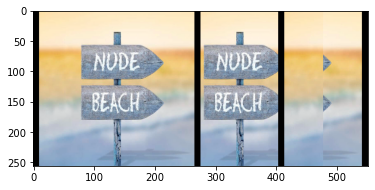

In [19]:
plt.imshow(image)

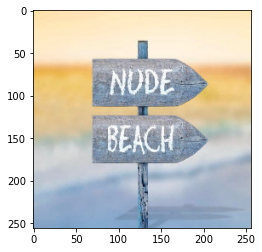

In [20]:
plt.imshow(c[0, ...])

In [21]:
# export

@tf.function
def train_step(mask_image, missing_image):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_missing = gen_model(mask_image)

        real = np.ones([BATCH_SIZE, 1])
        fake = np.ones([BATCH_SIZE, 1])

        real_output = disc_model(missing_image, training=True)
        fake_output = disc_model(gen_missing, training=True)

        gen_loss = generator_loss(real_output, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc_model.trainable_variables))


def train():

    start_time = datetime.now()
    saved_time = start_time

    for epoch in range(1, EPOCHS):
        steps = 1
        test = None

        while True:
            original = data.get_data(BATCH_SIZE)

            if original is None:
                break

            print(original.shape)

            mask_image, missing_image = get_masked_images(original)

            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1


            train_step(mask_image, missing_image)
            
            

In [22]:
original = data.get_data(BATCH)

In [23]:
# export

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [30]:
#export


d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE * 2)), INPUT_SHAPE[2])

d_dropout = 0.25
discriminator_optimizer = Adam(0.0001, 0.5)

disc_model = discriminator(d_input_shape)
disc_model.compile(loss=discriminator_loss, optimizer=discriminator_optimizer)

g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE * 2)), INPUT_SHAPE[2])

generator_optimizer = Adam(0.0001, 0.5)

gen_model = generator(g_input_shape)
gen_model.compile(loss=generator_loss, optimizer=generator_optimizer)

image = Input(shape=g_input_shape)

disc_model.trainable=False
generated_img = gen_model(image)
conf_generated_img = disc_model(generated_img)

combined = Model(image, [conf_generated_img, generated_img])

combined.compile(loss=['mse', 'mse'], optimizer=generator_optimizer)

train()

In [ ]:
run_experiment()